# Final Project - Basics of deep learning
Hello dear students,<br> This is the template notebook. Please copy it into your drive.

---
<br>

### Name and ID:
Student 1: Ofir Gur Cohen 206588642
<br>
Student 2: Oz Gemer 208426460

# Imports & Downloads

## Downloads
**Downloading explainer.md**

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1gjoiIh0W_cgKpxH-B1DKSDapotwHoA2k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gjoiIh0W_cgKpxH-B1DKSDapotwHoA2k
To: /content/explainer.md
100% 1.25k/1.25k [00:00<00:00, 2.24MB/s]


## Imports

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import random
from torchvision import models
import time
import copy
from google.colab import files
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

# Mount The Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1Rd3m40JgweV2Bm1TpJsebHFgFDApFfdD
# https://drive.google.com/file/d/1Rd3m40JgweV2Bm1TpJsebHFgFDApFfdD/view?usp=share_link

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Rd3m40JgweV2Bm1TpJsebHFgFDApFfdD
To: /content/resnet
100% 235M/235M [00:01<00:00, 162MB/s]


# Preprocessing

### Augmentation

In [ ]:
%%script echo skipping
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.RandomResizedCrop(299),  #size for inception architecture
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

## Split to Train and Test

In [ ]:
%%script echo skipping
trainset = torchvision.datasets.StanfordCars(root='./data', split='train', download=True, transform=data_transforms["train"])
testset = torchvision.datasets.StanfordCars(root='./data', split='test', download=True, transform=data_transforms["test"])

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_train.tgz to data/stanford_cars
Using downloaded and verified file: data/stanford_cars/car_devkit.tgz
Extracting data/stanford_cars/car_devkit.tgz to data/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting data/stanford_cars/cars_test.tgz to data/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [ ]:
%%script echo skipping
def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [ ]:
%%script echo skipping
print(device)
len(trainset.classes)
classes = trainset.classes

cuda


In [ ]:
%%script echo skipping
batch_size = 32
datasets = train_val_dataset(trainset)
dataloaders = {"train": torch.utils.data.DataLoader(datasets["train"], batch_size = batch_size, shuffle = True),
               "val": torch.utils.data.DataLoader(datasets["val"], batch_size = batch_size, shuffle = True),
              "test": torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)}

In [ ]:
%%script echo skipping
dataset_sizes = {"train": len(datasets["train"]), "val": len(datasets["val"]), "test":len(testset)}
print("train len: ", len(datasets["train"]))
print("val len: ", len(datasets["val"]))
print("test len: ", len(testset))

train len:  6108
val len:  2036
test len:  8041


# Train

In [ ]:
%%script echo skipping
def train_model(model, model_save_name, criterion, optimizer, sched, num_epochs=5,device='cuda'):
    start = time.time()
    train_results = []
    valid_results = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
              model.train()  # Set model to training modetrain_results
            else:
              model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()

                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if(phase == 'train'):
              train_results.append([epoch_loss,epoch_acc])
            if(phase == 'val'):
              valid_results.append([epoch_loss,epoch_acc])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model (Early Stopping) and Saving our model, when we get best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if(model_save_name is not None):
                  path = F"/content/drive/MyDrive/Colab Notebooks/Transfer Learning/{model_save_name}"
                  torch.save(model.state_dict(), path)

        print()
    # Calculating time it took for model to train
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)

    return model,train_results,valid_results

# Test

In [ ]:
%%script echo skipping
def test_model():
    with torch.no_grad():
      print("Predictions on Test Set:")
      model.eval()
      testloader = dataloaders["test"]
      pred = []
      file_names = []
      predicted_car = []
      predicted_class = []
      results = []
      test_acc = 0
      test_preds = []
      true_labels = []
      for inputs,labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs, 1)

        test_preds.append(pred.cpu().numpy())
        true_labels.append(labels.cpu().numpy())

        for i in range(len(inputs)):
          test_acc += 1 if pred[i] == labels[i] else 0
          results.append([int(pred[i] + 1), labels[i]])

      y_pred = np.concatenate(test_preds)
      y_true = np.concatenate(true_labels)
      acc = test_acc / len(testset) * 100
      return results, acc, y_pred, y_true

# Functions

In [ ]:
%%script echo skipping
def draw_graph(train,val,label):
  plt.plot(train,color='b',label='train',linestyle='--'),plt.plot(val,color='r',label='val')
  plt.xlabel('epochs')
  plt.ylabel(label)
  plt.legend()

def train_vs_val(train_results, val_results, label):
  train = []
  for item in train_results:
    train.append(item[1].item() if label== 'accuracy' else item[0])

  val = []
  for item in val_results:
    val.append(item[1].item() if label == 'accuracy' else item[0])

  draw_graph(train, val, label)

In [ ]:
%%script echo skipping
def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    # when we don't have any hidden layers
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 196))
    #when we have hidden layers
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.6))

        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))

    return classifier

**Predict Single Image**

In [ ]:
def predict_single_img(model, inputs):
  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  return preds

# Experiments

## Experiment - 1

### Model - Resnet

### Hyperparameters:

*   Epoches: 30
*   Optimizer - SGD
*   Criterion - CrossEntropyLoss





<h2><u> Resnet </u></h2>

In [ ]:
%%script echo skipping
model = models.resnet152(pretrained=True)
#model = models.resnet34(pretrained=True)
num_in_features = 2048 #512
print(model.fc)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Linear(in_features=2048, out_features=1000, bias=True)


In [ ]:
%%script echo skipping
# Freezing parameters
for param in model.parameters():
  param.require_grad = False

### creating custom classifier

In [ ]:
%%script echo skipping
hidden_layers = None #[1050,500]
classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)
model.fc = classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Sequential(
  (fc0): Linear(in_features=2048, out_features=196, bias=True)
)


In [ ]:
%%script echo skipping
epochs = 40
model.to(device)
model,train_results,valid_results = train_model(model, 'resnet.pt', criterion, optimizer, sched, epochs)

Epoch 1/40
----------
train Loss: 4.7381 Acc: 0.0612
val Loss: 4.0312 Acc: 0.1071

Epoch 2/40
----------
train Loss: 3.3097 Acc: 0.2264
val Loss: 3.5230 Acc: 0.2068

Epoch 3/40
----------
train Loss: 2.5897 Acc: 0.3602
val Loss: 2.9667 Acc: 0.3026

Epoch 4/40
----------
train Loss: 2.2110 Acc: 0.4316
val Loss: 2.5099 Acc: 0.3797

Epoch 5/40
----------
train Loss: 1.9519 Acc: 0.4933
val Loss: 2.4821 Acc: 0.4037

Epoch 6/40
----------
train Loss: 1.7722 Acc: 0.5380
val Loss: 2.4731 Acc: 0.4116

Epoch 7/40
----------
train Loss: 1.6226 Acc: 0.5696
val Loss: 2.2300 Acc: 0.4401

Epoch 8/40
----------
train Loss: 1.4746 Acc: 0.6107
val Loss: 2.0827 Acc: 0.4754

Epoch 9/40
----------
train Loss: 1.3815 Acc: 0.6297
val Loss: 2.0980 Acc: 0.4774

Epoch 10/40
----------
train Loss: 1.2212 Acc: 0.6704
val Loss: 2.2520 Acc: 0.4533

Epoch 11/40
----------
train Loss: 1.2033 Acc: 0.6749
val Loss: 1.7955 Acc: 0.5413

Epoch 12/40
----------
train Loss: 1.0849 Acc: 0.7115
val Loss: 1.8065 Acc: 0.5486

E

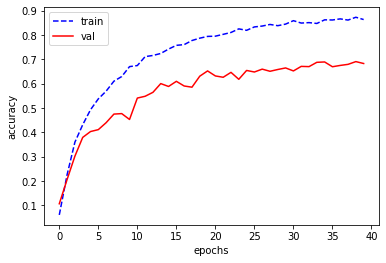

In [ ]:
%%script echo skipping
train_vs_val(train_results, valid_results, 'accuracy')

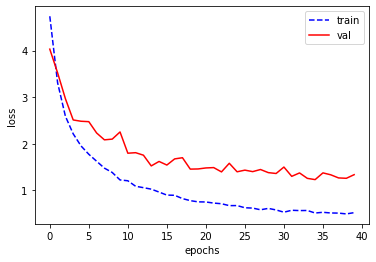

In [ ]:
%%script echo skipping
train_vs_val(train_results, valid_results, 'loss')

### Test the Model

In [ ]:
%%script echo skipping
resutls, acc, y_pred, y_true  = test_model()
print(acc)

Predictions on Test Set:
80.22634000746176


### Test Metrics

#### F1 Score

In [ ]:
%%script echo skipping
f1 = f1_score(y_true, y_pred,average='macro')

print("F1 score: ", f1)

#### Recall Score

In [ ]:
%%script echo skipping
recall = recall_score(y_true, y_pred,average='macro')

print("Recall score: ", recall)

#### Precision Score

In [ ]:
%%script echo skipping
precision = precision_score(y_true, y_pred,average='macro')

print("Precision score: ", precision)

#### Accuracy Score

In [ ]:
%%script echo skipping
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy score: ", accuracy)

Accuracy score:  0.8022634000746176


## Experiment - 2

### Model - Densenet

### Hyperparameters:

*   Epoches: 25
*   Optimizer - Adadelta
*   Criterion - CrossEntropyLoss


<h2><u>densenet</u></h2>

In [ ]:
%%script echo skipping
model = models.densenet161(pretrained=True)
num_in_features = 2208

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
%%script echo skipping
# Freezing parameters
for param in model.parameters():
  param.require_grad = False

In [ ]:
%%script echo skipping
hidden_layers = None #[1050,500]
classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)
model.classifier = classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters()) # Adadelta #weight
#optimizer = optim.Adam(model.parameters(), lr=0.001, momentum=0.9)
# Decay Learning Rate by a factor of 0.1 every 4 epochs
sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)

Sequential(
  (fc0): Linear(in_features=2208, out_features=196, bias=True)
)


In [ ]:
%%script echo skipping
epochs = 25
model.to(device)
model,train_results,valid_results = train_model(model, 'densenet.pt', criterion, optimizer, sched, epochs)

Epoch 1/25
----------
train Loss: 5.5247 Acc: 0.0046
val Loss: 5.3899 Acc: 0.0079

Epoch 2/25
----------
train Loss: 5.2653 Acc: 0.0080
val Loss: 9.1346 Acc: 0.0108

Epoch 3/25
----------
train Loss: 5.1789 Acc: 0.0126
val Loss: 5.1924 Acc: 0.0113

Epoch 4/25
----------
train Loss: 5.1079 Acc: 0.0144
val Loss: 5.1926 Acc: 0.0201

Epoch 5/25
----------
train Loss: 5.0231 Acc: 0.0269
val Loss: 5.3480 Acc: 0.0260

Epoch 6/25
----------
train Loss: 4.9482 Acc: 0.0314
val Loss: 5.0606 Acc: 0.0319

Epoch 7/25
----------
train Loss: 4.8557 Acc: 0.0391
val Loss: 5.7589 Acc: 0.0182

Epoch 8/25
----------
train Loss: 4.7661 Acc: 0.0419
val Loss: 4.8743 Acc: 0.0413

Epoch 9/25
----------
train Loss: 4.6186 Acc: 0.0547
val Loss: 4.7769 Acc: 0.0491

Epoch 10/25
----------
train Loss: 4.5259 Acc: 0.0655
val Loss: 4.7741 Acc: 0.0467

Epoch 11/25
----------
train Loss: 4.3724 Acc: 0.0758
val Loss: 5.1657 Acc: 0.0408

Epoch 12/25
----------
train Loss: 4.2613 Acc: 0.0956
val Loss: 5.1033 Acc: 0.0447

E

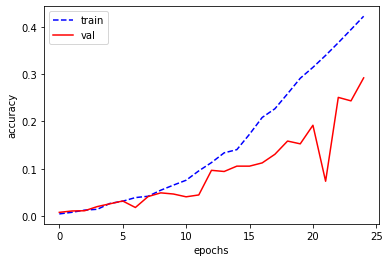

In [ ]:
%%script echo skipping
train_vs_val(train_results, valid_results, 'accuracy')

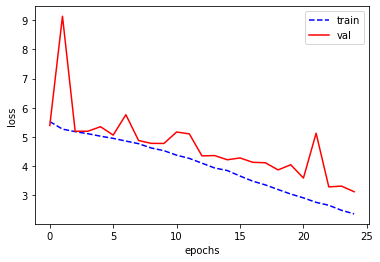

In [ ]:
%%script echo skipping
train_vs_val(train_results, valid_results, 'loss')

### Test the Model

In [ ]:
%%script echo skipping
resutls, acc, y_pred, y_true  = test_model()
print(acc)

Predictions on Test Set:
41.88533764457157


### Test Metrics

#### F1 Score

In [ ]:
%%script echo skipping
f1 = f1_score(y_true, y_pred,average='macro')

print("F1 score: ", f1)

F1 score:  0.41298739159611564


#### Recall Score

In [ ]:
%%script echo skipping
recall = recall_score(y_true, y_pred,average='macro')

print("Recall score: ", recall)

Recall score:  0.42059323445430574


#### Precision Score

In [ ]:
%%script echo skipping
precision = precision_score(y_true, y_pred,average='macro')

print("Precision score: ", precision)

Precision score:  0.5195971209112116


#### Accuracy Score

In [ ]:
%%script echo skipping
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy score: ", accuracy)

Accuracy score:  0.4188533764457157


## Experiment - 3

### Model - VGG

### Hyperparameters:

*   Epoches: 30
*   Optimizer - Adam
*   Criterion - CrossEntropyLoss


<h2><u>VGG</u></h2>

In [ ]:
%%script echo skipping
model = models.vgg19(pretrained=True)
num_in_features = 25088
print(model.classifier)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
%%script echo skipping
# Freezing parameters
for param in model.parameters():
  param.require_grad = False

In [ ]:
%%script echo skipping
hidden_layers = None #[1050,500]
classifier = build_classifier(num_in_features, hidden_layers, 196)
print(classifier)
model.classifier = classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
sched = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

Sequential(
  (fc0): Linear(in_features=25088, out_features=196, bias=True)
)


In [ ]:
%%script echo skipping
epochs = 30
model.to(device)
model,train_results,valid_results = train_model(model, None, criterion, optimizer, sched, epochs)

Epoch 1/30
----------
train Loss: 4.1949 Acc: 0.1467
val Loss: 4.5337 Acc: 0.1071

Epoch 2/30
----------
train Loss: 3.7342 Acc: 0.2084
val Loss: 4.2795 Acc: 0.1410

Epoch 3/30
----------
train Loss: 3.4088 Acc: 0.2641
val Loss: 4.1347 Acc: 0.1586

Epoch 4/30
----------
train Loss: 3.2123 Acc: 0.2996
val Loss: 4.0964 Acc: 0.1714

Epoch 5/30
----------
train Loss: 3.0104 Acc: 0.3319
val Loss: 4.0487 Acc: 0.1778

Epoch 6/30
----------
train Loss: 2.9058 Acc: 0.3590
val Loss: 3.9000 Acc: 0.2043

Epoch 7/30
----------
train Loss: 2.7479 Acc: 0.3869
val Loss: 3.9381 Acc: 0.1960

Epoch 8/30
----------
train Loss: 2.6720 Acc: 0.4034
val Loss: 3.9053 Acc: 0.2073

Epoch 9/30
----------
train Loss: 2.5344 Acc: 0.4348
val Loss: 3.8484 Acc: 0.2225

Epoch 10/30
----------
train Loss: 2.4886 Acc: 0.4430
val Loss: 3.8159 Acc: 0.2235

Epoch 11/30
----------
train Loss: 2.3938 Acc: 0.4581
val Loss: 3.8729 Acc: 0.2171

Epoch 12/30
----------
train Loss: 2.3534 Acc: 0.4632
val Loss: 3.8956 Acc: 0.2264

E

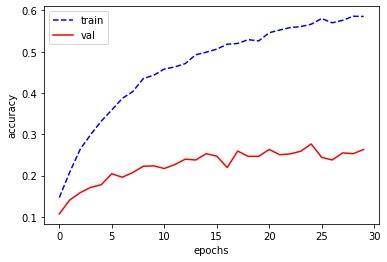

In [ ]:
%%script echo skipping
train_vs_val(train_results, valid_results, 'accuracy')

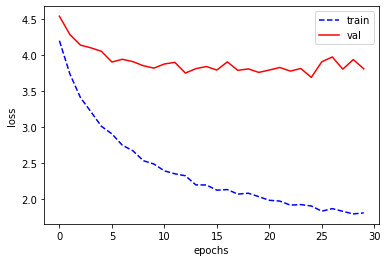

In [ ]:
%%script echo skipping
train_vs_val(train_results, valid_results, 'loss')

### Test the Model

In [ ]:
%%script echo skipping
resutls, acc, y_pred, y_true  = test_model()
print(acc)

Predictions on Test Set:
38.75139907971645


### Test Metrics

#### F1 Score

In [ ]:
%%script echo skipping
f1 = f1_score(y_true, y_pred,average='macro')

print("F1 score: ", f1)

F1 score:  0.38917481103083246


#### Recall Score

In [ ]:
%%script echo skipping
recall = recall_score(y_true, y_pred,average='macro')

print("Recall score: ", recall)


Recall score:  0.38685494387007824


#### Precision Score

In [ ]:
%%script echo skipping
precision = precision_score(y_true, y_pred,average='macro')

print("Precision score: ", precision)

Precision score:  0.4567536929665489


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Accuracy Score

In [ ]:
%%script echo skipping
accuracy = accuracy_score(y_true, y_pred)

print("Accuracy score: ", accuracy)

Accuracy score:  0.38751399079716453


# Test Enviorment

Test the enviorment for our best model - **resnet152**

### Upload image

In [ ]:
uploaded = files.upload()

Saving benz.jpg to benz.jpg


In [ ]:

image = Image.open(list(uploaded.keys())[0])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224, ))
])
img_tensor = transform(image)

### Vizualize Uploaded Image

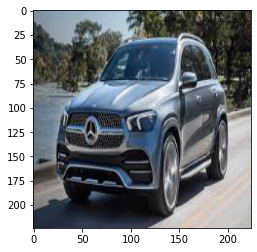

In [ ]:
plt.imshow(img_tensor.permute(1,2,0), cmap='gray')
plt.show()

### Predict Uploaded Image

In [ ]:
model = models.resnet152(pretrained=True)
classifier = nn.Sequential()
classifier.add_module('fc0', nn.Linear(2048, 196))
model.fc = classifier
model.load_state_dict(torch.load('resnet'))
model.eval()
model.cuda()
preds = predict_single_img(model, img_tensor.unsqueeze(0).cuda())
print("Predicted: Class " + str(preds.item()))

Predicted: Class 175
